<a href="https://colab.research.google.com/github/jjrodcast/MaskDectector/blob/master/VC_MaskDetector_Transfer%20Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Detector de Mascarrillas

These two major transfer learning scenarios look as follows:

-  **Finetuning the convnet**: Instead of random initializaion, we
   initialize the network with a pretrained network, like the one that is
   trained on imagenet 1000 dataset. Rest of the training looks as
   usual.
-  **ConvNet as fixed feature extractor**: Here, we will freeze the weights
   for all of the network except that of the final fully connected
   layer. This last fully connected layer is replaced with a new one
   with random weights and only this layer is trained.




In [3]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import gc
import cv2 

plt.ion()
%matplotlib inline  

# 0. Cargando los datos
---------


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
path_root = '/content/drive/MyDrive/Colab Notebooks/Diplomado_PUCP_IA/02 - Visión_artificial/proy/MaskDectector/dataset/'

# 1. Cargando el dataset

### Calculate the media and std of our dataset

In [6]:
train_dataset = torchvision.datasets.ImageFolder(path_root+'train',
                                                transform=transforms.Compose([
                                                    transforms.RandomResizedCrop(224), #224x224
                                                    transforms.ToTensor() # Convertir en un rango de 0-1
                                                ]))

print(train_dataset)

#val_dataset = torchvision.datasets.ImageFolder(path_root+'val',
#                                                transform=transforms.Compose([
#                                                    transforms.RandomResized(256), #224x224
#                                                    transforms.CenterCrop(224),
#                                                    transforms.ToTensor() # Convertir en un rango de 0-1
#                                                ]))

#print(val_dataset)





Dataset ImageFolder
    Number of datapoints: 2352
    Root location: /content/drive/MyDrive/Colab Notebooks/Diplomado_PUCP_IA/02 - Visión_artificial/proy/MaskDectector/dataset/train
    StandardTransform
Transform: Compose(
               RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=PIL.Image.BILINEAR)
               ToTensor()
           )


In [7]:
test_dataset = torchvision.datasets.ImageFolder(path_root+'test',
                                                transform=transforms.Compose([
                                                    transforms.Resize(256),
                                                    transforms.CenterCrop(224),
                                                    transforms.ToTensor() # Convertir en un rango de 0-1
                                               ]))

print(test_dataset)

Dataset ImageFolder
    Number of datapoints: 588
    Root location: /content/drive/MyDrive/Colab Notebooks/Diplomado_PUCP_IA/02 - Visión_artificial/proy/MaskDectector/dataset/test
    StandardTransform
Transform: Compose(
               Resize(size=256, interpolation=PIL.Image.BILINEAR)
               CenterCrop(size=(224, 224))
               ToTensor()
           )


In [8]:
%%time
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)

nimages = 0
mean = 0.0
var = 0.0
for i_batch, batch_target in enumerate(train_loader):
    batch = batch_target[0]
    # Rearrange batch to be the shape of [B, C, W * H]
    batch = batch.view(batch.size(0), batch.size(1), -1)
    # Update total number of images
    nimages += batch.size(0)
    # Compute MEAN and VAR here
    mean += batch.mean(2).sum(0) 
    var += batch.var(2).sum(0)

mean /= nimages
var /= nimages
std = torch.sqrt(var)

print(mean)
print(std)

tensor([0.5919, 0.4917, 0.4485])
tensor([0.2218, 0.2113, 0.2093])
CPU times: user 11.3 s, sys: 769 ms, total: 12.1 s
Wall time: 6min 33s


In [9]:
%%time
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)

nimages = 0
mean = 0.0
var = 0.0
for i_batch, batch_target in enumerate(test_loader):
    batch = batch_target[0]
    # Rearrange batch to be the shape of [B, C, W * H]
    batch = batch.view(batch.size(0), batch.size(1), -1)
    # Update total number of images
    nimages += batch.size(0)
    # Compute MEAN and VAR here
    mean += batch.mean(2).sum(0) 
    var += batch.var(2).sum(0)
mean /= nimages
var /= nimages
std = torch.sqrt(var)

print(mean)
print(std)

tensor([0.5339, 0.4509, 0.4170])
tensor([0.2486, 0.2323, 0.2305])
CPU times: user 2.87 s, sys: 192 ms, total: 3.07 s
Wall time: 1min 33s


### Data augmentation and normalization for training

In [10]:
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
                                 transforms.Resize(160),
                                 transforms.CenterCrop(160),
                                 transforms.RandomRotation(degrees=15),
                                 transforms.ColorJitter(),
                                 transforms.RandomHorizontalFlip(),
                                 transforms.ToTensor(),
                                 transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

    ]),
    'test': transforms.Compose([
        transforms.Resize(160),
        transforms.CenterCrop(160),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = path_root

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'test']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'test']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}

class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [11]:
dataset_sizes

{'test': 588, 'train': 2352}

In [12]:
class_names

['mask', 'nomask']

# 2. Mostrando un batch

Visualize a few images
^^^^^^^^^^^^^^^^^^^^^^
Let's visualize a few training images so as to understand the data
augmentations.



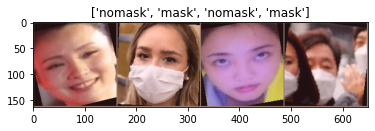

In [16]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.5946, 0.4933, 0.4498])
    std = np.array([0.2210, 0.2115, 0.2100])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

Training the model
------------------

Now, let's write a general function to train a model. Here, we will
illustrate:

-  Scheduling the learning rate
-  Saving the best model

In the following, parameter ``scheduler`` is an LR scheduler object from
``torch.optim.lr_scheduler``.



In [13]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_epoch = 0
    loss_values = [] ####
    acc_values = [] ####

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        #print(f'Epoch {epoch}/{num_epochs-1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
               scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'test' and epoch_acc > best_acc:
                best_epoch = epoch
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        loss_values.append(epoch_loss)  #####
        acc_values.appemnd(epoch_acc)   #####
        print()

    plt.plot(loss_values)   #####
    plt.plot(acc_values)   #####

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best Epoch: {}'.format(best_epoch))
    print('Best Test Acc: {:4f}'.format(best_acc))
    scheduler.step()

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

**Visualizing the model predictions**

Generic function to display predictions for a few images




In [14]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

**Evaluar** 

In [15]:
# Iterate over data.
def fx_evaluate_model(model, dataset):
    running_loss = 0.0
    running_corrects = 0
    model.eval()
    for inputs, labels in dataset:
        with torch.set_grad_enabled(False):
            inputs = inputs.to(device)
            labels = labels.to(device)
       
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            # statistics
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    value_loss = running_loss / len(dataset.dataset)
    value_acc = running_corrects.double() / len(dataset.dataset)

    print('Loss: {:4f}'.format(value_loss))
    print('Accuracy: {:4f}'.format(value_acc))

# Modelo 9: Resnet50 - Adam - Freeze 

In [227]:
model_9 = torchvision.models.resnet50(pretrained=True)
for param in model_9.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_9.fc.in_features
model_9.fc = nn.Linear(num_ftrs, 2)

model_9 = model_9.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opoosed to before.
optimizer_9 = optim.Adam(model_9.fc.parameters(), lr=0.006, 
                            betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_9, step_size=7, gamma=0.1)

Train and Evaluate

In [228]:
%%time
model_9 = train_model(model_9, criterion, optimizer_9, exp_lr_scheduler, num_epochs=50)

Epoch 0/49
----------
train Loss: 0.8651 Acc: 0.8265
test Loss: 0.1333 Acc: 0.9728

Epoch 1/49
----------
train Loss: 1.2002 Acc: 0.8520
test Loss: 0.4693 Acc: 0.9099

Epoch 2/49
----------
train Loss: 0.8054 Acc: 0.8920
test Loss: 0.8639 Acc: 0.8759

Epoch 3/49
----------
train Loss: 0.9951 Acc: 0.8831
test Loss: 0.0933 Acc: 0.9728

Epoch 4/49
----------
train Loss: 1.0060 Acc: 0.8805
test Loss: 0.3907 Acc: 0.9235

Epoch 5/49
----------
train Loss: 1.2405 Acc: 0.8724
test Loss: 0.1100 Acc: 0.9779

Epoch 6/49
----------
train Loss: 1.2756 Acc: 0.8895
test Loss: 0.1008 Acc: 0.9694

Epoch 7/49
----------
train Loss: 0.6453 Acc: 0.9192
test Loss: 0.0714 Acc: 0.9830

Epoch 8/49
----------
train Loss: 0.4900 Acc: 0.9290
test Loss: 0.6300 Acc: 0.9048

Epoch 9/49
----------
train Loss: 0.5173 Acc: 0.9239
test Loss: 0.0894 Acc: 0.9813

Epoch 10/49
----------
train Loss: 0.5152 Acc: 0.9252
test Loss: 0.1400 Acc: 0.9694

Epoch 11/49
----------
train Loss: 0.4626 Acc: 0.9303
test Loss: 0.1264 Acc

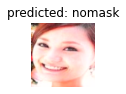

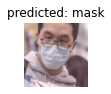

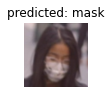

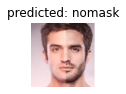

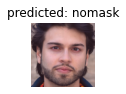

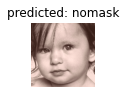

In [229]:
visualize_model(model_9)

In [230]:
# Save Model
PATH_SAVE = '/content/drive/MyDrive/Colab Notebooks/Diplomado_PUCP_IA/02 - Visión_artificial/proy/MaskDectector/models/'
torch.save(model_9, PATH_SAVE+'model_9.model')

In [231]:
# Load Model
loaded_model_9 = torch.load(PATH_SAVE+'model_9.model')
loaded_model_9.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [232]:
fx_evaluate_model(model=loaded_model_9, dataset=dataloaders['train'])

Loss: 0.114171
Accuracy: 0.986395


In [233]:
fx_evaluate_model(model=loaded_model_9, dataset=dataloaders['test'])

Loss: 0.071393
Accuracy: 0.982993


# Modelo 10: Resnet50 - Adam - Freeze 

In [200]:
model_10 = torchvision.models.resnet50(pretrained=True)
for param in model_10.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_10.fc.in_features
model_10.fc = nn.Linear(num_ftrs, 2)

model_10 = model_10.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opoosed to before.
optimizer_10 = optim.Adam(model_10.fc.parameters(), lr=0.002, 
                            betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_10, step_size=7, gamma=0.1)

train and evaluate

In [201]:
%%time
model_10 = train_model(model_10, criterion, optimizer_10, exp_lr_scheduler, num_epochs=50)

Epoch 0/49
----------
train Loss: 0.4253 Acc: 0.8622
test Loss: 0.2372 Acc: 0.9099

Epoch 1/49
----------
train Loss: 0.4306 Acc: 0.8741
test Loss: 0.1050 Acc: 0.9609

Epoch 2/49
----------
train Loss: 0.4554 Acc: 0.8724
test Loss: 0.2175 Acc: 0.9184

Epoch 3/49
----------
train Loss: 0.3756 Acc: 0.8992
test Loss: 0.0602 Acc: 0.9728

Epoch 4/49
----------
train Loss: 0.3786 Acc: 0.8878
test Loss: 0.1405 Acc: 0.9558

Epoch 5/49
----------
train Loss: 0.3460 Acc: 0.8997
test Loss: 0.7676 Acc: 0.7942

Epoch 6/49
----------
train Loss: 0.3770 Acc: 0.9018
test Loss: 0.0643 Acc: 0.9745

Epoch 7/49
----------
train Loss: 0.2528 Acc: 0.9218
test Loss: 0.1374 Acc: 0.9456

Epoch 8/49
----------
train Loss: 0.2301 Acc: 0.9239
test Loss: 0.0940 Acc: 0.9626

Epoch 9/49
----------
train Loss: 0.1973 Acc: 0.9341
test Loss: 0.0889 Acc: 0.9728

Epoch 10/49
----------
train Loss: 0.2137 Acc: 0.9175
test Loss: 0.0677 Acc: 0.9762

Epoch 11/49
----------
train Loss: 0.2197 Acc: 0.9158
test Loss: 0.0741 Acc

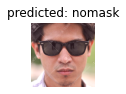

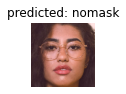

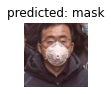

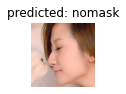

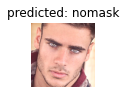

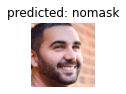

In [202]:
visualize_model(model_10)

In [203]:
# Save Model
PATH_SAVE = '/content/drive/MyDrive/Colab Notebooks/Diplomado_PUCP_IA/02 - Visión_artificial/proy/MaskDectector/models/'
torch.save(model_10, PATH_SAVE+'model_10.model')

In [204]:
# Load Model
loaded_model_10 = torch.load(PATH_SAVE+'model_10.model')
loaded_model_10.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [205]:
fx_evaluate_model(model=loaded_model_10, dataset=dataloaders['train'])

Loss: 0.032695
Accuracy: 0.990646


In [206]:
fx_evaluate_model(model=loaded_model_10, dataset=dataloaders['test'])

Loss: 0.065037
Accuracy: 0.979592


In [246]:
hh = loaded_model_10.named_parameters()
hh.

<generator object Module.named_parameters at 0x7f40f17c8780>

# Modelo 13: Resnet50 - AdamW - Freeze 

In [21]:
model_13 = torchvision.models.resnet50(pretrained=True)
for param in model_13.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_13.fc.in_features
model_13.fc = nn.Linear(num_ftrs, 2)

model_13 = model_13.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opoosed to before.
optimizer_13 = optim.AdamW(model_13.fc.parameters(), lr=0.006, betas=(0.9, 0.999), 
                           eps=1e-08, weight_decay=0.01, amsgrad=False)
#optimizer_conv = optim.Adam(model_conv.fc.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_13, step_size=7, gamma=0.1)

Train and evaluate

In [ ]:
%%time 
model_13 = train_model(model_13, criterion, optimizer_13, exp_lr_scheduler, num_epochs=50)

Epoch 0/49
----------
train Loss: 0.8901 Acc: 0.8529
test Loss: 3.3024 Acc: 0.6446

Epoch 1/49
----------
train Loss: 0.9480 Acc: 0.8682
test Loss: 1.8877 Acc: 0.7466

Epoch 2/49
----------
train Loss: 1.0263 Acc: 0.8733
test Loss: 0.5149 Acc: 0.9184

Epoch 3/49
----------
train Loss: 1.0011 Acc: 0.8784
test Loss: 0.4641 Acc: 0.9133

Epoch 4/49
----------
train Loss: 1.0434 Acc: 0.8784
test Loss: 0.1641 Acc: 0.9626

Epoch 5/49
----------
train Loss: 0.8849 Acc: 0.8793
test Loss: 0.5929 Acc: 0.8929

Epoch 6/49
----------
train Loss: 1.4309 Acc: 0.8571
test Loss: 0.2130 Acc: 0.9643

Epoch 7/49
----------
train Loss: 0.5542 Acc: 0.9175
test Loss: 0.1246 Acc: 0.9728

Epoch 8/49
----------
train Loss: 0.4236 Acc: 0.9247
test Loss: 0.0935 Acc: 0.9745

Epoch 9/49
----------
train Loss: 0.3836 Acc: 0.9320
test Loss: 0.4254 Acc: 0.9269

Epoch 10/49
----------
train Loss: 0.4119 Acc: 0.9324
test Loss: 0.1025 Acc: 0.9711

Epoch 11/49
----------


In [ ]:
visualize_model(model_13)

In [ ]:
# Save Model
PATH_SAVE = '/content/drive/MyDrive/Colab Notebooks/Diplomado_PUCP_IA/02 - Visión_artificial/proy/MaskDectector/models/'
torch.save(model_13, PATH_SAVE+'model_13.model')

In [ ]:
# Load Model
loaded_model_13 = torch.load(PATH_SAVE+'model_13.model')
loaded_model_13.eval()

In [ ]:
fx_evaluate_model(model=loaded_model_13, dataset=dataloaders['train'])

In [ ]:
fx_evaluate_model(model=loaded_model_13, dataset=dataloaders['test'])

# Modelo 15: Resnet50 - Adamax - Freeze 

In [ ]:
model_15 = torchvision.models.resnet50(pretrained=True)
for param in model_15.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_15.fc.in_features
model_15.fc = nn.Linear(num_ftrs, 2)

model_15 = model_15.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opoosed to before.
optimizer_15 = optim.Adamax(model_15.fc.parameters(), lr=0.002, 
                            betas=(0.9, 0.999), eps=1e-08, weight_decay=0)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_15, step_size=7, gamma=0.1)

In [ ]:
%%time
model_15 = train_model(model_15, criterion, optimizer_15, exp_lr_scheduler, num_epochs=50)

In [ ]:
visualize_model(model_15)

In [ ]:
# Save Model
PATH_SAVE = '/content/drive/MyDrive/Colab Notebooks/Diplomado_PUCP_IA/02 - Visión_artificial/proy/MaskDectector/models/'
torch.save(model_15, PATH_SAVE+'model_15.model')

In [ ]:
# Load Model
loaded_model_15 = torch.load(PATH_SAVE+'model_15.model')
loaded_model_15.eval()

In [ ]:
fx_evaluate_model(model=loaded_model_15, dataset=dataloaders['train'])

In [ ]:
fx_evaluate_model(model=loaded_model_15, dataset=dataloaders['test'])